#### **This code accompanies the manuscript "Compact Model Parameter Extraction via Derivative-Free Optimization"**
**Paper link:** https://arxiv.org/abs/2406.16355

*Written by Rafael Perez Martinez (Stanford University)*

Note: Before running this diode example, it is necessary to install [ngspice](https://ngspice.sourceforge.io/) and [Optuna](https://optuna.org/). This notebook is designed to be run in [Google Colab](https://colab.google/).

In [1]:
"""
MIT License

Copyright (c) 2024 Rafael Perez Martinez

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
""";

In [2]:
# NGSPICE Installation (can take up to 5-10 mins)
%%capture
!apt-get update
!apt-get install -y libxaw7-dev libxaw7
!wget http://sourceforge.net/projects/ngspice/files/ng-spice-rework/42/ngspice-42.tar.gz -O ngspice-42.tar.gz
!tar -zxvf ngspice-42.tar.gz
%cd ngspice-42
!./configure --enable-xspice --enable-osdi --disable-debug --with-readline=yes
!make clean
!make
!make install
!which ngspice
!ngspice --version

In [3]:
# Optuna installation
%%capture
!pip install optuna

#### This example corresponds to Section 3.3 (Diamond Schottky Diode Fitting Example) of the manuscript

#### We first do a test/train split, train the model, set the correct hyperparameters, and assess the model using test data


In [4]:
import itertools
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
from sklearn.model_selection import train_test_split
import joblib
import json
import subprocess
import optuna

# Download diode data from GitHub
url = 'https://raw.githubusercontent.com/rafapm/dfo_parameter_extraction/main/notebooks/Diode_ex/ngspice_notebook_and_files/diamond_diode_meas.csv'
!wget -P /content/ {url}

base_path = '/content'

df_HEMT_meas = pd.read_csv(f"{base_path}/diamond_diode_meas.csv")
va_meas = np.array(df_HEMT_meas['va_meas'])
ia_meas = np.array(df_HEMT_meas['ia_meas'])

va_unique = np.unique(va_meas)
va_len = len(va_unique)

va_start = va_unique[0]
va_stop = va_unique[-1]
va_step = (va_stop - va_start) / (va_len - 1)
va_step = round(va_step, 2)

data_len = len(va_meas)
ind = np.arange(data_len)
train_ind, test_ind = train_test_split(ind, test_size=0.20, random_state=42, shuffle=True)

train_ind = np.sort(train_ind)
test_ind = np.sort(test_ind)

va_train = va_meas[train_ind]
ia_meas_train = ia_meas[train_ind]
va_test = va_meas[test_ind]
ia_meas_test = ia_meas[test_ind]

df_train = pd.DataFrame({'va_train': va_train, 'ia_meas_train': ia_meas_train})
df_train.to_csv(f"{base_path}/diamond_diode_meas_train.csv", index=False)

df_test = pd.DataFrame({'va_test': va_test, 'ia_meas_test': ia_meas_test})
df_test.to_csv(f"{base_path}/diamond_diode_meas_test.csv", index=False)

--2024-07-13 06:24:20--  https://raw.githubusercontent.com/rafapm/dfo_parameter_extraction/main/notebooks/Diode_ex/ngspice_notebook_and_files/diamond_diode_meas.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 694 [text/plain]
Saving to: ‘/content/diamond_diode_meas.csv’

diamond_diode_meas. 100%[===================>]     694  --.-KB/s    in 0s      

2024-07-13 06:24:20 (38.2 MB/s) - ‘/content/diamond_diode_meas.csv’ saved [694/694]



In [5]:
# Set hyperparameters
epsilon = 1e-10
delta = np.sqrt(0.15)

def calc_error(ia_meas, ia_sim, epsilon, delta):
    ia_sim = np.maximum(ia_sim, -epsilon + 1e-15)   # Ensure ia_sim is not too close to zero
    ia_meas = np.maximum(ia_meas, -epsilon + 1e-15) # Ensure ia_sim is not too close to zero

    # Calculate the log-transformed simulated and measured currents
    log_I_sim = np.log(1 + ia_sim/epsilon)
    log_I_meas = np.log(1 + ia_meas/epsilon)
    error = np.abs(log_I_sim - log_I_meas)

    # Calculates penalized errors
    penalized_errors = np.where(error <= delta, error**2, delta**2)

    # Return the mean of the penalized errors
    return np.mean(penalized_errors)

In [6]:
file_name = 'iv_characteristics_diode'

temp = 25
voltages = {
    'va_start': va_start,
    'va_stop': va_stop,
    'va_step': va_step,
}

spice_content = """Diode IV characteristics simulation
.model DiodeModel d (IS={IS} N={N} RS={RS})

.TEMP {temp}
.OPTIONS TNOM={temp}

va n1 0 dc=0
d1 n1 0 DiodeModel

.control
op
show all
dc va {va_start} {va_stop} {va_step}
print -i(va) > ia-va.txt
.endc

.end
"""

def generate_spice_file(voltages, temp, params, file_name, spice_content):
    va_start = voltages['va_start']
    va_stop = voltages['va_stop']
    va_step = voltages['va_step']
    RS = params['RS']
    IS = params['IS']
    N = params['N']

    spice_content = spice_content.format(
        va_start=va_start,
        va_stop=va_stop,
        va_step=va_step,
        temp=temp,
        RS=RS,
        IS=IS,
        N=N
    )
    with open(f"{base_path}/{file_name}.sp", "w") as file:
        file.write(spice_content)

def run_ngspice(file_name):
    command = f"ngspice -b {base_path}/{file_name}.sp -o output.log"

    try:
        result = subprocess.run(command, shell=True, check=True)
        if result.returncode == 0:
            return True
        else:
            print("There was an error executing the command.")
            return False
    except subprocess.CalledProcessError as e:
        print(f"Failed with error: {e}")
        return False

def read_data(filename):
    va = []
    ia = []
    with open(filename, 'r') as file:
        lines = file.readlines()
        data_section = False
        for line in lines:
            if 'Index' in line:
                data_section = True
                continue
            if data_section and line.strip() and not line.startswith("----"):
                values = line.split()
                if len(values) == 3:
                    try:
                        va.append(float(values[1]))
                        ia.append(float(values[2]))
                    except ValueError:
                        continue
    return va, ia

def simulate_and_evaluate(**params):
    # Generate SPICE file and run simulation
    generate_spice_file(voltages, temp, params, file_name, spice_content)
    run_ngspice(file_name)

    va_sim, ia_sim = read_data(f'{base_path}/ngspice-42/ia-va.txt')
    va_sim = np.array(va_sim)
    ia_sim = np.array(ia_sim)

    ia_sim_train = ia_sim[train_ind]
    ia_sim_test = ia_sim[test_ind]

    # Calculate error
    train_error = calc_error(ia_meas_train, ia_sim_train, epsilon, delta)
    test_error = calc_error(ia_meas_test, ia_sim_test, epsilon, delta)

    return train_error, test_error

### **Note:** This method is probabilistic (i.e., you get a different result everytime you run it)
### You can make it deterministic by changing the sampler_behavior to 1 and adding a seed_value

[I 2024-07-13 06:24:38,027] A new study created in memory with name: no-name-cbc8c426-e278-4012-bc0a-fa83cfcb5914
[I 2024-07-13 06:24:38,062] Trial 0 finished with value: 0.12033859736767963 and parameters: {'N': 1.0507979025745755, 'IS': 1.3318136687429908e-23, 'RS': 114.54523694564722}. Best is trial 0 with value: 0.12033859736767963.
[I 2024-07-13 06:24:38,086] Trial 1 finished with value: 0.1183339133688629 and parameters: {'N': 1.010827605197663, 'IS': 4.773543263868096e-23, 'RS': 144.8146544466719}. Best is trial 1 with value: 0.1183339133688629.
[I 2024-07-13 06:24:38,111] Trial 2 finished with value: 0.14427341318333214 and parameters: {'N': 0.6255853104638363, 'IS': 4.185319668991098e-25, 'RS': 102.57336016504149}. Best is trial 1 with value: 0.1183339133688629.
[I 2024-07-13 06:24:38,138] Trial 3 finished with value: 0.11631717588497315 and parameters: {'N': 0.9408098436506365, 'IS': 1.2292172115487824e-25, 'RS': 122.84166121973556}. Best is trial 3 with value: 0.116317175884

Best trial parameters: {'N': 1.1423025519014856, 'IS': 6.572758211875424e-25, 'RS': 123.69513182456627}
Train Error for best trial: 0.00929610076229879
Test Error for best trial: 0.00506724468427597
Best parameters from train/val split saved to best_parameters.json
Results saved to /content/diamond_diode_Optuna_250_trials_train_val_split.csv


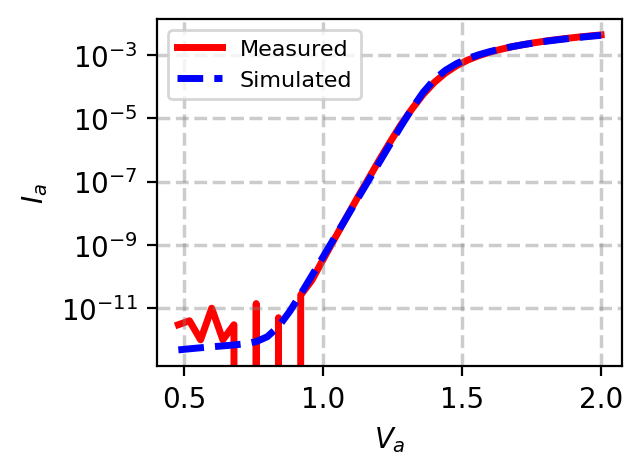

In [7]:
sampler_behavior = 1  # 0 for probabilistic and 1 for deterministic
seed_value = 3        # If determinisitc, define the seed value here
num_trials = 250

# Define the desired parameters to be extracted along with the appropiate ranges
def objective(trial):
    params = {
         "N": trial.suggest_float("N", 0.5, 1.5),
         "IS": trial.suggest_float("IS", 1e-25, 1e-22, log=True),
         "RS": trial.suggest_float("RS", 100, 150)
    }
    train_error, test_error = simulate_and_evaluate(**params)
    trial.set_user_attr('test_error', test_error)
    return train_error

optuna.logging.set_verbosity(optuna.logging.INFO)

def create_optuna_study(sampler_behavior=0, seed=seed_value):
    if sampler_behavior == 1:
        sampler = optuna.samplers.TPESampler(seed=seed)
    else:
        sampler = optuna.samplers.TPESampler()
    study = optuna.create_study(directions=['minimize'], sampler=sampler)
    return study

study = create_optuna_study(sampler_behavior=sampler_behavior, seed=seed_value)
study.optimize(objective, n_trials=num_trials)
joblib.dump(study, f"{base_path}/diamond_diode_study_train_val_split.pkl")

# Get the best parameters
best_trial = study.best_trial
best_params = best_trial.params
print("Best trial parameters:", best_params)

# Evaluate the function with the best parameters
train_error, test_error = simulate_and_evaluate(**best_params)
print("Train Error for best trial:", train_error)
print("Test Error for best trial:", test_error)

# Save best parameters to a JSON file
with open(f"{base_path}/best_parameters_train_val_split.json", "w") as json_file:
    json.dump(best_params, json_file, indent=4)

print("Best parameters from train/val split saved to best_parameters.json")

file_path = f"{base_path}/diamond_diode_Optuna_250_trials_train_val_split.csv"

# Write the results to a CSV file
with open(file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Trial', 'Train Error', 'Test Error', 'Parameters'])
    for trial in study.trials:
        writer.writerow([
            trial.number,
            trial.value,
            trial.user_attrs.get('test_error'),
            trial.params
        ])

print(f'Results saved to {file_path}')

# Simulate the best parameters found and plot IV characteristics
va_sim, ia_sim = read_data(f'{base_path}/ngspice-42/ia-va.txt')
va_sim = np.array(va_sim)
ia_sim = np.array(ia_sim)


fig, ax = plt.subplots(figsize=(3, 2.25), dpi=200)
ax.grid(True, which='both', color='grey', linestyle='--', linewidth=1.25, zorder=0, alpha=0.4)
plt.semilogy(va_meas, ia_meas, linewidth=2.5, color='red', linestyle='-', zorder=1, label='Measured')
plt.semilogy(va_sim, ia_sim, linewidth=2.5, color='blue', linestyle='--', zorder=2, label='Simulated')
plt.xlabel(f'$V_a$')
plt.ylabel(f'$I_a$')
plt.rcParams['legend.fontsize'] = 8
ax.legend()
plt.show()

### Retrain (with fewer trials) using all data and with tighter parameter ranges


[I 2024-07-13 06:24:58,711] A new study created in memory with name: no-name-2f9322ae-649b-4bc8-b5d6-175ec82ab6f6
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:650: UserWarning: Fixed parameter 'RS' with value 123.69513182456627 is out of range for distribution FloatDistribution(high=128.0, log=False, low=124.0, step=None).
  warnings.warn(
[I 2024-07-13 06:24:58,743] Trial 0 finished with value: 0.008428643105268467 and parameters: {'N': 1.1423025519014856, 'IS': 6.572758211875424e-25, 'RS': 123.69513182456627}. Best is trial 0 with value: 0.008428643105268467.
[I 2024-07-13 06:24:58,765] Trial 1 finished with value: 0.057265884249843566 and parameters: {'N': 1.1742128606113347, 'IS': 3.741460220489711e-24, 'RS': 124.00045749926937}. Best is trial 0 with value: 0.008428643105268467.
[I 2024-07-13 06:24:58,786] Trial 2 finished with value: 0.009047780595451088 and parameters: {'N': 1.1593032344421392, 'IS': 1.1604015086770085e-24, 'RS': 124.36935437907519}. Best is tri

Best trial parameters: {'N': 1.1420252258944013, 'IS': 6.602575169021874e-25, 'RS': 127.3708226489643}
Error for best trial: 0.00817100464882319
Best parameters from all data saved to best_parameters.json
Results saved to /content/diamond_diode_Optuna_50_trials_all_data.csv


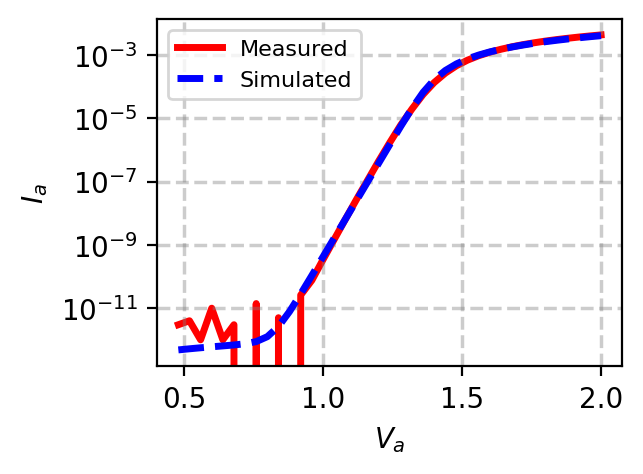

In [8]:
sampler_behavior = 1  # 0 for probabilistic and 1 for deterministic
seed_value = 1        # If determinisitc, define the seed value here
num_trials = 50

def simulate_and_evaluate(**params):
    generate_spice_file(voltages, temp, params, file_name, spice_content)
    run_ngspice(file_name)

    va_sim, ia_sim = read_data(f'{base_path}/ngspice-42/ia-va.txt')
    va_sim = np.array(va_sim)
    ia_sim = np.array(ia_sim)

    # Calculate error
    error = calc_error(ia_meas, ia_sim, epsilon, delta)
    return error

# Tighten the ranges of the parameters
def objective(trial):
    params = {
         "N": trial.suggest_float("N", 1.12, 1.25),
         "IS": trial.suggest_float("IS", 5e-25, 5e-24),
         "RS": trial.suggest_float("RS", 124, 128)
    }
    error = simulate_and_evaluate(**params)
    return error

optuna.logging.set_verbosity(optuna.logging.INFO)

def create_optuna_study(sampler_behavior=0, seed=seed_value):
    if sampler_behavior == 1:
        sampler = optuna.samplers.TPESampler(seed=seed)
    else:
        sampler = optuna.samplers.TPESampler()

    study = optuna.create_study(directions=['minimize'], sampler=sampler)
    return study

study = create_optuna_study(sampler_behavior=sampler_behavior, seed=seed_value)

# Start with best parameters found from train/test split

# Load parameters from a JSON file
def load_parameters_from_json(file_path):
    with open(file_path, 'r') as file:
        parameters = json.load(file)
    return parameters

file_path_train_test_params= f"{base_path}/best_parameters_train_val_split.json"
train_test_parameters = load_parameters_from_json(file_path_train_test_params)
study.enqueue_trial(train_test_parameters)

study.optimize(objective, n_trials=num_trials)
joblib.dump(study, f"{base_path}/diamond_diode_study_all_data.pkl")

# Get the best parameters
best_trial = study.best_trial
best_params = best_trial.params
print("Best trial parameters:", best_params)

# Evaluate the function with the best parameters
error = simulate_and_evaluate(**best_params)
print("Error for best trial:", error)

# Save best parameters to a JSON file
with open(f"{base_path}/best_parameters_all_data.json", "w") as json_file:
    json.dump(best_params, json_file, indent=4)

print("Best parameters from all data saved to best_parameters.json")

file_path = f"{base_path}/diamond_diode_Optuna_50_trials_all_data.csv"

# Write the results to a CSV file
with open(file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Trial', 'Error','Parameters'])
    for trial in study.trials:
        writer.writerow([
            trial.number,
            trial.value,
            trial.params
        ])

print(f'Results saved to {file_path}')

va_sim, ia_sim = read_data(f'{base_path}/ngspice-42/ia-va.txt')
va_sim = np.array(va_sim)
ia_sim = np.array(ia_sim)

fig, ax = plt.subplots(figsize=(3, 2.25), dpi=200)
ax.grid(True, which='both', color='grey', linestyle='--', linewidth=1.25, zorder=0, alpha=0.4)
plt.semilogy(va_meas, ia_meas, linewidth=2.5, color='red', linestyle='-', zorder=1, label='Measured')
plt.semilogy(va_sim, ia_sim, linewidth=2.5, color='blue', linestyle='--', zorder=2, label='Simulated')
plt.xlabel(f'$V_a$')
plt.ylabel(f'$I_a$')
plt.rcParams['legend.fontsize'] = 8
ax.legend()
plt.show()